### Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, classification_report

### Load Dataset

In [2]:
df = pd.read_csv('iris.csv', header=None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']

### Split dataset into train and test

In [3]:
def train_test_split(df, test_size=0.25, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    
    if isinstance(test_size, float):
        test_size = int(test_size * df.shape[0])
        
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    
    test_df = df.iloc[test_indices, :]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [4]:
train_df, test_df = train_test_split(df, random_state=1)
train_df.shape, test_df.shape

((113, 5), (37, 5))

### Class Node - represents each node of the decision tree

In [5]:
class Node:
    def __init__(self, data, is_leaf=False):
        self.is_leaf = is_leaf                                       
        self.entropy = self.__calculate_entropy(data)                
        self.samples= np.unique(data[:, -1], return_counts=True)[1]  
        self.prediction = None                                       
        self.left = None                                             
        self.right = None
        self.question = None                                         
        self.gain_ratio = None                                       
        self.split_col = None
        self.split_col_name = None                                   
        
    def display(self):
        for i in range(len(self.samples)):
            if self.samples[i] > 0:
                print("Count of", i, "=", self.samples[i])

        print("Current Entropy is =", self.entropy)
        if self.is_leaf == False:
            print("Splitting on " + str(self.split_col_name), "with gain ratio", str(self.gain_ratio))
        else:
            print("Reached leaf node")
        print()
        
    def __calculate_entropy(self, data):
        counts = np.unique(data[:, -1], return_counts=True)[1]
        probabilities = counts / counts.sum()

        entropy = -sum(probabilities * np.log2(probabilities))
        if entropy == -0.0:
            entropy = 0.0
        return entropy

In [6]:
class DecisionTree:
    def __init__(self):
        self.root = None  
        
    # calculates entropy of a node
    def __calculate_entropy(self, data):
        counts = np.unique(data[:, -1], return_counts=True)[1]
        probabilities = counts / counts.sum()

        entropy = -sum(probabilities * np.log2(probabilities))
        if entropy == -0.0:
            entropy = 0.0
        return entropy
        
    # calculates overall entropy after split
    def __calculate_overall_entropy(self, data_below, data_above):
        p_data_below = len(data_below) / (len(data_below) + len(data_above))
        p_data_above = len(data_above) / (len(data_below) + len(data_above))

        overall_entropy = ((p_data_below * self.__calculate_entropy(data_below)) + 
                                    (p_data_above * self.__calculate_entropy(data_above)))
        return overall_entropy
        
    # calculates gain_ratio of the split
    def __gain_ratio(self, node, data_below, data_above):
        info_gain = node.entropy - self.__calculate_overall_entropy(data_below, data_above)
        
        d_data_below = len(data_below) / (len(data_below) + len(data_above))
        d_data_above = len(data_above) / (len(data_below) + len(data_above))

        split_number = -(d_data_below * np.log2(d_data_below) + d_data_above * np.log2(d_data_above))

        gain_ratio = info_gain / split_number
        return gain_ratio
        
    # returns the data after split
    def __split_data(self, data, split_column, split_value):
        data_below = data[data[:, split_column] <= split_value]
        data_above = data[data[:, split_column] > split_value]

        return data_below, data_above
        
    # checks which split results in max decrease in entropy
    def __determine_best_split(self, data, potential_splits):
        overall_entropy = 999

        for column_index in potential_splits:
            for value in potential_splits[column_index]:
                data_below, data_above = self.__split_data(data, column_index, value)
                curr_entropy = self.__calculate_overall_entropy(data_below, data_above)

                if curr_entropy <= overall_entropy:
                    overall_entropy = curr_entropy
                    best_split_col = column_index
                    best_split_value = value

        return best_split_col, best_split_value
        
    # Potential splits is a dictionary {index of column : list of all possible split values for that column}
    def __get_potential_splits(self, data):
        potential_splits = {}

        for column_index in range(data.shape[1] - 1):
            potential_splits[column_index] = []

            values = data[:, column_index]
            unique_values = np.unique(values)

            for index in range(1, (len(unique_values))):
                current_value = unique_values[index]
                previous_value = unique_values[index-1]

                potential_split = (current_value + previous_value) / 2
                potential_splits[column_index].append(potential_split)

        return potential_splits
    
    # to check if there are any possible splits available
    def __is_splitting_possible(self, potential_splits):
        for k, v in potential_splits.items():
            if len(v) != 0:
                return True
        return False
      
    def fit(self, df):
        self.root = self.__train_tree(df.values, df.columns)
        
    # private function for recursion of training
    def __train_tree(self, data, columns=None):
        node = Node(data)                        
        
        potential_splits = self.__get_potential_splits(data)  
        
        # base case - if node is pure or there are no further splits possible
        if len(np.unique(data[:, -1])) == 1 or self.__is_splitting_possible(potential_splits) == False:
            node.is_leaf = True
            classes, counts = np.unique(data[:, -1], return_counts=True)
            node.prediction = classes[counts.argmax()]
            return node
        
        # recursive part - when node is not pure
        node.is_leaf = False
        split_col, split_val = self.__determine_best_split(data, potential_splits)  
        data_below, data_above = self.__split_data(data, split_col, split_val)

        node.left = self.__train_tree(data_below, columns)           
        node.right = self.__train_tree(data_above, columns)         

        
        # Updating parameters of node
        node.gain_ratio = self.__gain_ratio(node, data_below, data_above)
        node.split_col = split_col
        node.split_col_name = columns[split_col]
        node.question = str(split_col) + " <= " + str(split_val)

        return node  
    
    def display(self, node=None, level=0):
        if node is None:
            node = self.root
            
        print("Level", level)
        node.display()
        
        if node.right is not None:
            self.display(node.right, level+1)
        if node.left is not None:
            self.display(node.left, level+1)
    
    # predicts for the entire dataframe
    def predict(self, df_test):
        if isinstance(df_test, pd.DataFrame):
            data = df_test.values
        else:
            data = df_test
        rv = []
        for arr in data:
            classification = self.__classify(arr)
            rv.append(classification)
            
        return rv
        
    # internal function to predict for one row
    def __classify(self, arr, node=None):
        if node is None:
            node = self.root
            
        if node.is_leaf == True:
            return node.prediction
        else:
            question = node.question
            col, _, val = question.split()
            
            if arr[int(col)] <= float(val):   
                return self.__classify(arr, node.left)
            else:
                return self.__classify(arr, node.right)
    
    # accuracy = total correct perdictions / total predictions
    def accuracy(self, y_pred, y_test):        
        is_correct = (y_pred == y_test)
        return len(is_correct[is_correct == True]) / len(y_test)

### Creating object of Decision Tree and training the model

In [7]:
clf = DecisionTree()
clf.fit(train_df)
clf.display() 

Level 0
Count of 0 = 37
Count of 1 = 37
Count of 2 = 39
Current Entropy is = 1.5845131607145686
Splitting on petal_width with gain ratio 1.0000000000000002

Level 1
Count of 0 = 37
Count of 1 = 39
Current Entropy is = 0.9995003941817588
Splitting on petal_length with gain ratio 0.6519085664993656

Level 2
Count of 0 = 3
Count of 1 = 37
Current Entropy is = 0.38431154412649704
Splitting on petal_width with gain ratio 0.31672885635448317

Level 3
Count of 0 = 33
Current Entropy is = 0.0
Reached leaf node

Level 3
Count of 0 = 3
Count of 1 = 4
Current Entropy is = 0.9852281360342515
Splitting on petal_length with gain ratio 0.5294617736385714

Level 4
Count of 0 = 3
Current Entropy is = 0.0
Reached leaf node

Level 4
Count of 0 = 3
Count of 1 = 1
Current Entropy is = 0.8112781244591328
Splitting on sepal_width with gain ratio 1.0

Level 5
Count of 0 = 3
Current Entropy is = 0.0
Reached leaf node

Level 5
Count of 0 = 1
Current Entropy is = 0.0
Reached leaf node

Level 2
Count of 0 = 34
Co

### Accuracy of test data

In [8]:
y_pred = clf.predict(test_df)
clf.accuracy(y_pred, test_df.iloc[:, -1])

0.972972972972973

### Confusion Matrix

In [9]:
confusion_matrix(y_true=test_df.values[:, -1], y_pred=y_pred)

array([[13,  0,  0],
       [ 0, 12,  1],
       [ 0,  0, 11]], dtype=int64)

### CLassification Report

In [10]:
print(classification_report(y_true=test_df.values[:, -1], y_pred=y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.92      1.00      0.96        11

      micro avg       0.97      0.97      0.97        37
      macro avg       0.97      0.97      0.97        37
   weighted avg       0.98      0.97      0.97        37



## Decision Boundary
- For this, the tree is built along two columns only - Second and Third

### Load data

In [11]:
from sklearn import datasets
iris = datasets.load_iris()
data = pd.DataFrame(iris.data)
data['label'] = iris.target
data.label = data.label.astype(int)

### Train Test Split

In [12]:
small_train_df, small_test_df = train_test_split(data.iloc[:, [1, 2, -1]], test_size=0.25, random_state=1)
small_train_df = data.iloc[:, [1, 2, -1]]

### Visualization of data

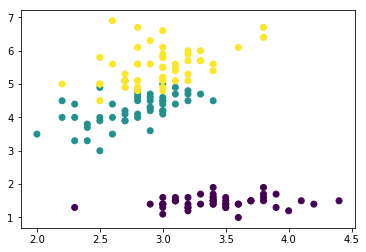

In [13]:
plt.scatter(small_train_df.values[:, 0], small_train_df.values[:, 1], c=small_train_df.values[:, -1])

### Creating and Traing Decision Tree

In [14]:
clf2 = DecisionTree()
clf2.fit(small_train_df)

### Plotting Decision Boundary

In [15]:
def makegrid(x1, x2, h=0.02):
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x1.min() - 1, x2.max() + 2
    
    a = np.arange(x1_min, x1_max, h)
    b = np.arange(x2_min, x2_max, h)
    
    xx, yy = np.meshgrid(a, b)
    return xx, yy

In [16]:
a, b = makegrid(small_train_df.values[:, 0], small_train_df.values[:, 1])
x1 = a.ravel()
x2 = b.ravel() # converts 2D to 1D
a.shape, b.shape

((395, 220), (395, 220))

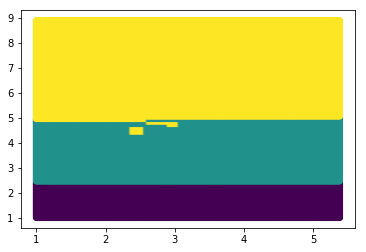

In [17]:
plot_data = np.c_[x1, x2]
predictions = clf2.predict(plot_data)
plt.scatter(x1, x2, c=predictions)
plt.show()